In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
import cv2
import tensorflow.keras.layers as layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [8]:

dirpath = '/Users/yangjunyu/py_project/DL/images/stanfor_dogs/'
os.listdir(dirpath)

imgSize = (128, 128)
imgShape = (128, 128, 3)
batchSize = 800
epoch = 100

# generator
trainDataGenerator = ImageDataGenerator(rescale=1/255,
                                        rotation_range=40,
                                        width_shift_range=0.3,
                                        height_shift_range=0.3,
                                        shear_range=0.3,
                                        zoom_range=0.2,
                                        fill_mode="nearest",
                                        validation_split=0.2)
valDataGenerator = ImageDataGenerator(rescale=1/255, validation_split=0.2)
testDataGenerator = ImageDataGenerator(rescale=1/255)

#  資料生成
trainBatch = trainDataGenerator.flow_from_directory(
    directory=dirpath+'train',
    target_size=imgSize,
    class_mode='categorical',
    shuffle=True,
    batch_size=batchSize,
    seed=200,
    subset='training',
)
valBatch = valDataGenerator.flow_from_directory(
    directory=dirpath+'train',
    target_size=imgSize,
    class_mode='categorical',
    shuffle=True,
    batch_size=batchSize,
    seed=200,
    subset='validation',
)
testBatch = testDataGenerator.flow_from_directory(
    dirpath,
    class_mode=None,
    batch_size=1,
    shuffle=False,
    target_size=imgSize,
    classes=['test'],
)

Found 10800 images belonging to 120 classes.
Found 1200 images belonging to 120 classes.
Found 8580 images belonging to 1 classes.


In [32]:

# model
base_model = InceptionResNetV2(
    include_top=False,
    weights='imagenet',
    input_tensor = None,
    input_shape=imgShape,
)

# freeze the weight
for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.25)(x)
output_layer = layers.Dense(120, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=output_layer)
# model.summary()

In [22]:
# show the model stucture (截圖用)
model1 = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(120, activation="softmax")
])
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, None, None, 1536)  54336736 
 onal)                                                           
                                                                 
 global_average_pooling2d_6   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 1024)              1573888   
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_13 (Dense)            (None, 120)               123000    
                                                                 
Total params: 56,033,624
Trainable params: 55,973,080


In [31]:
# compile
model.compile(
    # optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3, decay=1e-3,momentum=0.9),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, decay=1e-3),
    loss='categorical_crossentropy', metrics=['accuracy'])


# continue
model.load_weights("/Users/yangjunyu/py_project/DL/Models/CNN/ResNet50/hw3_vision/checkpoint/main.h5")


# callback
model_checkpoint_callback = ModelCheckpoint(
    filepath="/Users/yangjunyu/py_project/DL/Models/CNN/ResNet50/hw3_vision/checkpoint/mainnb.h5",
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max', verbose=1,
    save_best_only=True)
model_earlyStopping_callback = EarlyStopping(
    monitor="val_accuracy", patience=5, mode="max", verbose=1,)
ModelReduceLROnPlateau = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=3, verbose=0, min_lr=0.00001)
# fit
history = model.fit(
    trainBatch,
    steps_per_epoch=trainBatch.samples // batchSize,
    validation_data=valBatch,
    validation_steps=valBatch.samples // batchSize,
    epochs=epoch,
    verbose=1,
    callbacks=[model_checkpoint_callback, model_earlyStopping_callback, ModelReduceLROnPlateau]
)

Epoch 1/100


2022-05-27 19:48:04.998328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 30/900 [>.............................] - ETA: 27:04 - loss: 4.7870 - accuracy: 0.0111

KeyboardInterrupt: 

2022-05-27 22:24:32.123211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


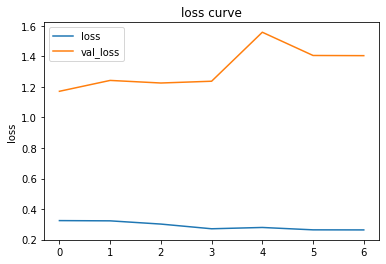

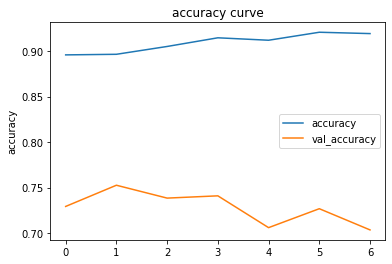

In [34]:
# load_weight
model.load_weights("/Users/yangjunyu/py_project/DL/Models/CNN/ResNet50/hw3_vision/checkpoint/main.h5")
# predict
prediction = model.predict(testBatch)
prediction_label = prediction.argmax(axis=1)
filename = testBatch.filenames
for i in range(len(filename)):
    filename[i] = filename[i].replace('test/', '')
outputdf = pd.DataFrame()
outputdf['Name'] = filename
outputdf['Label'] = prediction_label
outputdf.to_csv('/Users/yangjunyu/py_project/DL/Models/CNN/ResNet50/hw3_vision/prediction.csv', index=False)

# show image
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('loss curve')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('accuracy curve')
plt.ylabel('accuracy')
plt.legend()
plt.show()